<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/roberta_ell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing new libraries**

In [ ]:
!pip install nltk
!pip install wordcloud
!pip install transformers
!pip install emoji==0.6.0
!pip3 install tokenizers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49732 sha256=7efaffcfe1bac05721bae26819ce61a68989dfb98db72c4db388efc6ef01c023
  Stored in directory: /root/.cache/pip/wheels/70/2a/7f/1a0012c86b1061c6ee2ed9568b1f830f857a51e8

# **Importing libraries**

In [ ]:
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
from transformers import TFAutoModel, AutoTokenizer
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from transformers import RobertaTokenizer, TFRobertaModel
nltk.download('punkt')
ROBERTA_MODEL = "roberta-base"

# Other required libraries
import math
import os
import pandas as pd
import numpy as np
import re
import copy
import sys
import gc
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

import torch
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

transformers version: 4.27.3


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **General functions**

## **Rounding Off to Custom Decimal Places**

In [ ]:
def roundPartial(value, resolution):
    return round (value / resolution) * resolution

## **Set parameters**

In [ ]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Plot loss and accuracy**

In [ ]:
def plot_loss_accuracy(history, col_list):
    fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
    fig.tight_layout(pad=5.0)
    for idx, col in enumerate(col_list):

        ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
        ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[0, idx].set_xlabel('Epochs', size=10)
        ax[0, idx].set_title('Loss: ' + col)

        ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
        ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[1, idx].set_xlabel('Epochs', size=10)
        ax[1, idx].set_title('Accuracy: ' + col)

## **Text Encode**

In [ ]:
def text_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

## **Busild Base Model**

In [ ]:
def build_base_model(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64', name = 'attention_masks')
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    output = tf.keras.layers.Dense(dense_dim)(x)
    #output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss=loss,metrics=metrics)
    
    return model

## **Custom metric**

In [ ]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [ ]:
def MCRMSE(y_preds, y_trues):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False)
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores

def loss_fn(outputs, targets):
    loss_fn = torch.nn.MSELoss()
    loss = torch.sqrt(loss_fn(outputs, targets))
    return loss

# **Read input files**

In [ ]:
input_train_df = pd.read_csv('train.csv')
input_test_df = pd.read_csv('test.csv')
label_cols = input_train_df.columns[2:]
orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


# **Spliting the data**
Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [ ]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])

X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

# **Model building**

In [ ]:
set_config_param()
MAX_LENGTH = 512
epochs = 5
batch_size = 8
dropout = .1
learning_rate = .00005
number_of_hidden_layer = 1
hidden_layer_node_count = 64
trainable_flag = False
retrain_layer_count = 0

In [ ]:
col = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
targets = np.array(df_train[col], dtype="float32")

MAX_LEN = 512

def bert_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

from transformers import RobertaTokenizer, TFRobertaModel



bert_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
bert_model = TFRobertaModel.from_pretrained(ROBERTA_MODEL)

train_input_ids,train_attention_masks = bert_encode(df_train['full_text'], bert_tokenizer, MAX_LEN)
loss = tf.keras.losses.mae
metrics=tf.keras.metrics.mae


def build_model(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64')
    attention_masks = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64')
 
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    x = tf.keras.layers.Dense(dense_dim,activation='sigmoid')(x)
    output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss=loss,metrics=metrics)
    
    return model

BERT= build_model(bert_model,learning_rate=1e-5)
BERT.summary()

history = BERT.fit((train_input_ids,train_attention_masks),targets,batch_size =4,        
                epochs=2,
                validation_split = 0.2
                )



Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model_11 (TFRoberta  TFBaseModelOutputWi  124645632  ['input_11[0][0]',               
 Model)                         thPoolingAndCrossAt               'input_12[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model_4 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

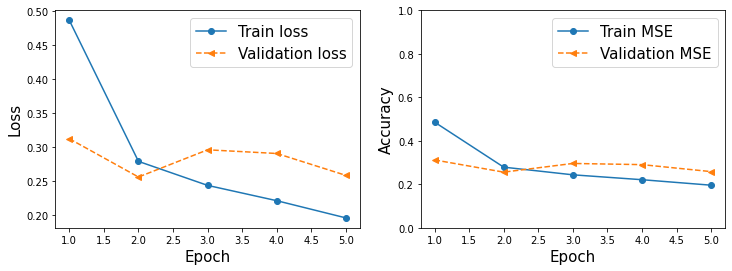

In [ ]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.2)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_test = orig_train_df[ : splits[0]], orig_train_df[splits[0] : ]

label_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
y_train = np.array(df_train[label_cols], dtype="float32")
y_test = np.array(df_test[label_cols], dtype="float32")

MAX_LEN = 512
epochs = 5
batch_size = 4
learning_rate = 1e-5
validation_split = .2

roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
roberta_model = TFRobertaModel.from_pretrained(ROBERTA_MODEL)

train_input_ids,train_attention_masks = text_encode(df_train['full_text'], roberta_tokenizer, MAX_LEN)
test_input_ids,test_attention_masks = text_encode(df_test['full_text'], roberta_tokenizer, MAX_LEN)

loss = tf.keras.losses.mse
metrics=tf.keras.metrics.mse

ROBERTA_v1 = build_base_model(roberta_model,learning_rate=1e-5)
ROBERTA_v1.summary()

history_v1 = ROBERTA_v1.fit((train_input_ids,train_attention_masks),
                            y_train,
                            batch_size = batch_size,        
                            epochs = epochs,
                            validation_split = validation_split
                            )

history_v1_df = pd.DataFrame(history_v1.history)
print(history_v1_df.T)

score_v1 = ROBERTA_v1.evaluate([test_input_ids, test_attention_masks], 
                               y_test
                              ) 
print(pd.DataFrame(score_v1))

predictions_v1 = ROBERTA_v1.predict([test_input_ids, test_attention_masks])
df_pred_v1 = pd.DataFrame(predictions_v1, columns=['pred_' + c for c in label_cols])
#print("Before transform...")
#print(df_pred_v1.head())
#print(df_pred_v1.tail())

for col in label_cols:
    df_pred_v1['transformed_pred_' + col] = df_pred_v1['pred_' + col].apply(lambda x : roundPartial(x, .5))
#print("After transform...")
print(df_pred_v1.head())
print(df_pred_v1.tail())

df_compare_v1= pd.merge(df_test, df_pred_v1, left_index=True, right_index=True)

x_arr = np.arange(len(history_v1_df['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history_v1_df['loss'], '-o', label='Train loss')
ax.plot(x_arr, history_v1_df['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history_v1_df['mean_squared_error'], '-o', label='Train MSE')
ax.plot(x_arr, history_v1_df['val_mean_squared_error'], '--<', label='Validation MSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

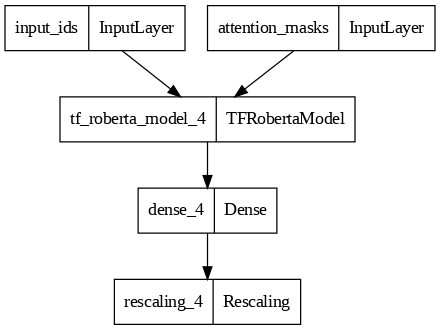

In [ ]:
keras.utils.plot_model(ROBERTA_v1, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
df_compare_v1